In [21]:
import sys
import spotipy
import yaml
import spotipy.util as util
from pprint import pprint
import json
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import plotly.graph_objects as go
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator
from plotly.subplots import make_subplots
sns.set()

## Spotipy Credentials and API Calls

In [3]:
# Get Spotipy credentials from config
def load_config():
    stream = open('config.yaml')
    user_config = yaml.load(stream, Loader=yaml.FullLoader)
    return user_config

user_config = load_config()

In [4]:
# Initialize Spotify API token
def get_token(SCOPE):
    token = util.prompt_for_user_token(user_config['username'], scope=SCOPE, client_id=user_config['client_id'], client_secret=user_config['client_secret'], redirect_uri=user_config['redirect_uri'])
    return token

In [5]:
sp = spotipy.Spotify(auth=get_token('playlist-read-private'))

In [6]:
# A function to extract track names and URIs from a playlist
def get_playlist_info(username, playlist_uri):
    # initialize vars
    offset = 0
    tracks, uris, names, artists = [], [], [], []

    # get playlist id and name from URI
    playlist_id = playlist_uri.split(':')[2]
    playlist_name = sp.user_playlist(username, playlist_id)['name']

    # get all tracks in given playlist (max limit is 100 at a time --> use offset)
    while True:
        results = sp.user_playlist_tracks(username, playlist_id, offset=offset)
        tracks += results['items']
        if results['next'] is not None:
            offset += 100
        else:
            break
        
    # get track metadata
    for track in tracks:
        names.append(track['track']['name'])
        artists.append(track['track']['artists'][0]['name'])
        uris.append(track['track']['uri'])
    
    return playlist_name, names, artists, uris

In [7]:
# Extract features from each track in a playlist
def get_features_for_playlist(df, username, uri):
  
    # get all track metadata from given playlist
    playlist_name, names, artists, uris = get_playlist_info(username, uri)
    
    # iterate through each track to get audio features and save data into dataframe
    for name, artist, track_uri in zip(names, artists, uris):
        # print(json.dumps(track_uri, indent=4))              
        # ^ DEBUG STATEMENT ^
        
        # access audio features for given track URI via spotipy 
        audio_features = sp.audio_features(track_uri)

        # get relevant audio features
        feature_subset = [audio_features[0][col] for col in df.columns if col not in ["name", "artist", "track_URI", "playlist"]]

        # compose a row of the dataframe by flattening the list of audio features
        row = [name, artist, track_uri, *feature_subset, playlist_name]
        df.loc[len(df.index)] = row
    return df

In [8]:
df = pd.DataFrame(columns=['name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'playlist'])


In [9]:
df = get_features_for_playlist(df, user_config['username'], 'spotify:playlist:0AQoxkZoBFUI2RSXgOyug9')
df


,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist
0,A Million Doubts,Glassio,spotify:track:4fb2SOMtpKsleLxBcUrKzW,0.295000,0.500,0.886,0.862000,0.1050,-6.171,0.0430,177.949,0.310,shlumpy shwednesday
1,Hold Back The River,James Bay,spotify:track:7tmtOEDxPN7CWaQWBsG1DY,0.052600,0.715,0.715,0.000000,0.0936,-7.364,0.0904,134.923,0.506,shlumpy shwednesday
2,Waiting On the World to Change,John Mayer,spotify:track:5imShWWzwqfAJ9gXFpGAQh,0.157000,0.578,0.756,0.000232,0.2490,-5.820,0.1150,176.739,0.663,shlumpy shwednesday
3,Come On Get Higher,Matt Nathanson,spotify:track:38YgZVHPWOWsKrsCXz6JyP,0.241000,0.672,0.623,0.000000,0.0848,-5.699,0.0297,92.018,0.617,shlumpy shwednesday
4,Rhythm Of Love,Plain White T's,spotify:track:6MDTpYxPFL0wtFd0pjfKws,0.356000,0.531,0.542,0.000000,0.1190,-7.721,0.0432,171.878,0.726,shlumpy shwednesday
5,New Soul,Yael Naim,spotify:track:476JcJ3TpAuCOlGdCmomGm,0.733000,0.769,0.371,0.000037,0.1060,-8.522,0.0326,100.001,0.653,shlumpy shwednesday
6,Mess Is Mine,Vance Joy,spotify:track:7BVwi9cIzSc6tpyxsp47vJ,0.047000,0.595,0.723,0.028600,0.0995,-8.256,0.0349,108.043,0.272,shlumpy shwednesday
7,Step,Vampire Weekend,spotify:track:78J9MBkAoqfvyeEpQKJDzD,0.591000,0.624,0.724,0.000008,0.1010,-7.113,0.1010,78.008,0.624,shlumpy shwednesday
8,Say,John Mayer,spotify:track:6wZI4mdT8JwXgkGURnBQiq,0.541000,0.485,0.723,0.000001,0.0750,-6.565,0.0317,167.845,0.541,shlumpy shwednesday
9,Only Love,Ben Howard,spotify:track:2uhEKg8kIzpdvz4gyy6x8W,0.300000,0.545,0.485,0.001370,0.1190,-9.941,0.1510,80.401,0.341,shlumpy shwednesday


In [10]:
sp = spotipy.Spotify(auth=get_token('user-top-read'))

df = pd.DataFrame(columns=['track_name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'])

top_artists = [x for x in sp.current_user_top_artists(limit=10, time_range='short_term')['items']]
artist_queue=[*top_artists]

while len(df) < 2000 and artist_queue:
        artist = artist_queue.pop(0)
        if artist['name'] in df['artist'].unique():
                continue
        related_artists = sp.artist_related_artists(artist['uri'])
        artist_queue.extend(related_artists['artists'])
        artist_top_tracks = sp.artist_top_tracks(artist['uri'])
        for track in artist_top_tracks['tracks'][:10]:
                track_name = track['name']
                artist = track['artists'][0]['name']
                track_uri = track['uri']
                
                # access audio features for given track URI via spotipy
                audio_features = sp.audio_features(track_uri)
                
                # get relevant audio features
                feature_subset = [audio_features[0][col] for col in df.columns if col not in ["track_name", "artist", "track_URI"]]

                # compose a row of the dataframe by flattening the list of audio features
                row = [track_name, artist, track_uri, *feature_subset]
                df.loc[len(df.index)] = row

df

,track_name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,False Confidence,Noah Kahan,spotify:track:7nDFTHHwfe32a8qdp9XqPy,0.16300,0.414,0.663,0,0.1380,-7.770,0.0456,108.980,0.330
1,Someone Like You (feat. Joy Oladokun),Noah Kahan,spotify:track:0hiHNxqKGf3GZgVTIOAiiK,0.46800,0.614,0.526,0,0.0939,-7.492,0.0603,177.913,0.366
2,Hurt Somebody,Noah Kahan,spotify:track:2Zg0aB5oVQlbQE1vzQmIIY,0.34400,0.638,0.510,0,0.2120,-6.485,0.3050,114.576,0.448
3,Mess,Noah Kahan,spotify:track:1BlQWQgGP84r4GYUVty4Ar,0.17600,0.442,0.826,0,0.0978,-5.320,0.0775,80.848,0.601
4,Part of Me,Noah Kahan,spotify:track:1o5WgxPWvoVgo20DQItKOE,0.06770,0.689,0.687,0,0.0805,-7.832,0.0376,109.986,0.248
...,...,...,...,...,...,...,...,...,...,...,...,...
2003,Put Your Hands Up,Forest Blakk,spotify:track:57X2jAov78d6K39SOWJqaJ,0.18400,0.627,0.653,4.29e-05,0.0958,-7.291,0.0476,124.999,0.388
2004,If You Love Her - Acoustic,Forest Blakk,spotify:track:615LwsUs7WA2KvSRRmXAUK,0.85200,0.516,0.257,0,0.1100,-11.063,0.0331,153.617,0.444
2005,If You Love Her - Mark McCabe Remix,Forest Blakk,spotify:track:2MaGdDg1cbXTywMf93cEZt,0.00179,0.587,0.806,1.56e-06,0.0928,-5.098,0.0344,122.971,0.404
2006,I Wish I Knew,Forest Blakk,spotify:track:59fi2USYlHpzOOfjlPenJI,0.64600,0.575,0.566,0,0.2440,-7.417,0.0233,107.033,0.294


## Principal Component Analysis (PCA)

In [11]:
non_features = ['track_name', 'artist', 'track_URI']
track_info = df[non_features]
df_X = df.drop(columns=non_features)
df_X.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.1630,0.414,0.663,0,0.1380,-7.770,0.0456,108.980,0.330
1,0.4680,0.614,0.526,0,0.0939,-7.492,0.0603,177.913,0.366
2,0.3440,0.638,0.510,0,0.2120,-6.485,0.3050,114.576,0.448
3,0.1760,0.442,0.826,0,0.0978,-5.320,0.0775,80.848,0.601
4,0.0677,0.689,0.687,0,0.0805,-7.832,0.0376,109.986,0.248


In [12]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df_X)

In [13]:
pca = PCA()
pca.fit(X_std);

In [14]:
# The attribute shows how much variance is explained by each of the nine features
evr = pca.explained_variance_ratio_
evr

array([0.28232599, 0.13989467, 0.11969374, 0.11484411, 0.10773816,
       0.08624937, 0.07580761, 0.04919182, 0.02425454])

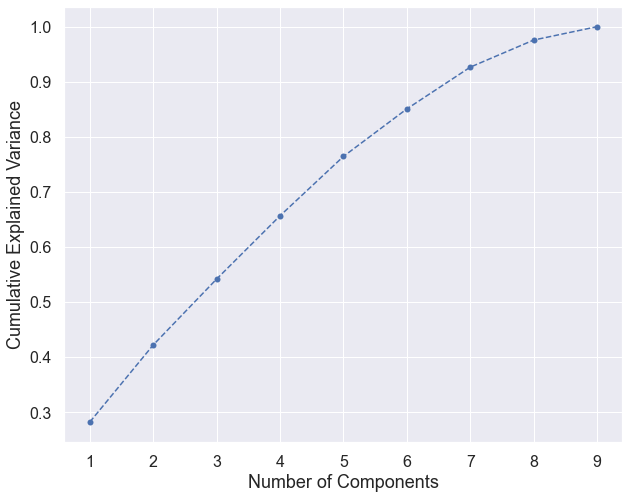

In [15]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(df_X.columns)+1), evr.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig = plt.savefig("./visualizations/cumulative_variance_plot.png")
plt.show()

In [16]:
for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps)
pca = PCA(n_components=n_comps)
pca.fit(X_std)
scores_pca = pca.transform(X_std)

Number of components: 6


## K-Means Clustering

Finding the elbow point of the WCSS (within cluster sum of squares) curve using the YellowBrick `KElbowVisualizer`

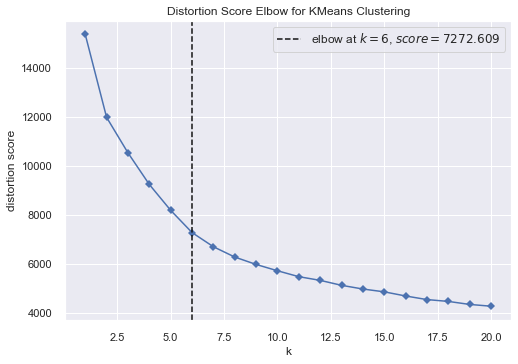

Optimal number of clusters: 6


In [17]:
visualizer = KElbowVisualizer(KMeans(init='k-means++', random_state=42), k=(1,21), timings=False)
visualizer.fit(scores_pca)
visualizer.show()
n_clusters = visualizer.elbow_value_
print("Optimal number of clusters:", n_clusters)

Finding the elbow point of the WCSS (within cluster sum of squares) curve using the kneed `KneeLocator`

In [22]:
wcss = []
max_clusters = 21
for i in range(1, max_clusters):
    kmeans_pca = KMeans(i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)
n_clusters = KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee
print("Optimal number of clusters", n_clusters)

Optimal number of clusters 6


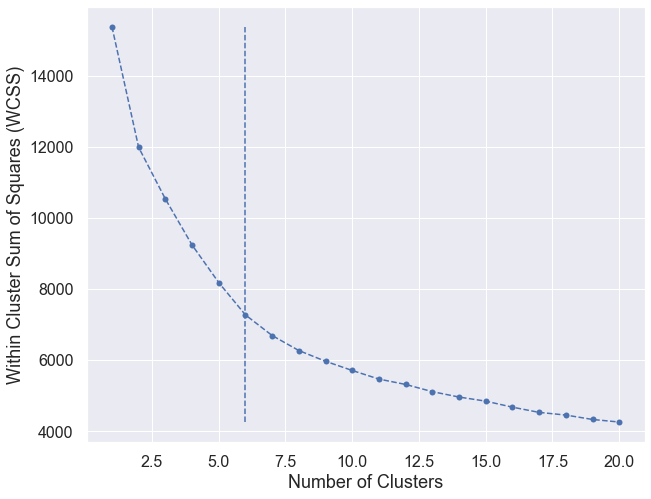

In [23]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.vlines(KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee, ymin=min(wcss), ymax=max(wcss), linestyles='dashed')
plt.xlabel('Number of Clusters', fontsize=18)
plt.ylabel('Within Cluster Sum of Squares (WCSS)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.savefig("./visualizations/num_clusters.png")
plt.show()

In [24]:
kmeans_pca = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca);

## Analysis and Visualization

In [25]:
df_seg_pca_kmeans = pd.concat([df_X.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_seg_pca_kmeans.columns.values[(-1*n_comps):] = ["Component " + str(i+1) for i in range(n_comps)]
df_seg_pca_kmeans['Cluster'] = kmeans_pca.labels_
df_seg_pca_kmeans.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Cluster
0,0.1630,0.414,0.663,0,0.1380,-7.770,0.0456,108.980,0.330,0.213038,1.549511,-0.770213,-0.196857,-0.555124,0.644965,5
1,0.4680,0.614,0.526,0,0.0939,-7.492,0.0603,177.913,0.366,0.559450,1.068489,0.803634,0.749789,-1.199633,-1.257287,5
2,0.3440,0.638,0.510,0,0.2120,-6.485,0.3050,114.576,0.448,-0.087762,-0.193045,1.432282,-0.659813,0.328193,0.818252,2
3,0.1760,0.442,0.826,0,0.0978,-5.320,0.0775,80.848,0.601,-1.156064,0.614867,-1.238588,-0.327501,-0.602447,1.087820,5
4,0.0677,0.689,0.687,0,0.0805,-7.832,0.0376,109.986,0.248,-0.247150,0.357301,-0.794391,0.202016,-0.749399,0.558221,5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


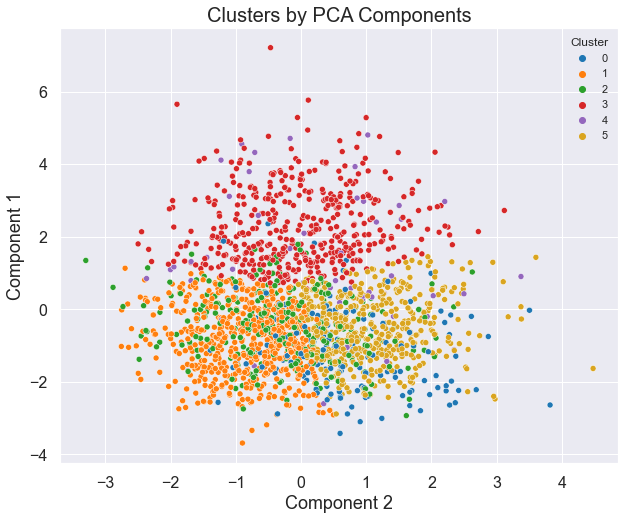

In [27]:
x = df_seg_pca_kmeans['Component 2']
y = df_seg_pca_kmeans['Component 1']
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(x, y, hue=df_seg_pca_kmeans['Cluster'], palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'goldenrod'])
plt.title('Clusters by PCA Components', fontsize=20)
plt.xlabel("Component 2", fontsize=18)
plt.ylabel("Component 1", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("./visualizations/clusters-2d.png")

In [28]:
df['Cluster'] = df_seg_pca_kmeans['Cluster']
df

,track_name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Cluster
0,False Confidence,Noah Kahan,spotify:track:7nDFTHHwfe32a8qdp9XqPy,0.16300,0.414,0.663,0,0.1380,-7.770,0.0456,108.980,0.330,5
1,Someone Like You (feat. Joy Oladokun),Noah Kahan,spotify:track:0hiHNxqKGf3GZgVTIOAiiK,0.46800,0.614,0.526,0,0.0939,-7.492,0.0603,177.913,0.366,5
2,Hurt Somebody,Noah Kahan,spotify:track:2Zg0aB5oVQlbQE1vzQmIIY,0.34400,0.638,0.510,0,0.2120,-6.485,0.3050,114.576,0.448,2
3,Mess,Noah Kahan,spotify:track:1BlQWQgGP84r4GYUVty4Ar,0.17600,0.442,0.826,0,0.0978,-5.320,0.0775,80.848,0.601,5
4,Part of Me,Noah Kahan,spotify:track:1o5WgxPWvoVgo20DQItKOE,0.06770,0.689,0.687,0,0.0805,-7.832,0.0376,109.986,0.248,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,Put Your Hands Up,Forest Blakk,spotify:track:57X2jAov78d6K39SOWJqaJ,0.18400,0.627,0.653,4.29e-05,0.0958,-7.291,0.0476,124.999,0.388,5
2004,If You Love Her - Acoustic,Forest Blakk,spotify:track:615LwsUs7WA2KvSRRmXAUK,0.85200,0.516,0.257,0,0.1100,-11.063,0.0331,153.617,0.444,3
2005,If You Love Her - Mark McCabe Remix,Forest Blakk,spotify:track:2MaGdDg1cbXTywMf93cEZt,0.00179,0.587,0.806,1.56e-06,0.0928,-5.098,0.0344,122.971,0.404,5
2006,I Wish I Knew,Forest Blakk,spotify:track:59fi2USYlHpzOOfjlPenJI,0.64600,0.575,0.566,0,0.2440,-7.417,0.0233,107.033,0.294,3


In [29]:
def make_normalized_df(df, col_sep):
    non_features = df[df.columns[:col_sep]]
    features = df[df.columns[col_sep:]]
    norm = MinMaxScaler().fit_transform(features)
    scaled = pd.DataFrame(norm, index=df.index, columns = df.columns[col_sep:])
    return pd.concat([non_features, scaled], axis=1)

cluster_labels = df['Cluster']
orig = df.drop(columns=['Cluster'])
values_df = make_normalized_df(orig, 3)
values_df.insert(3, 'cluster', cluster_labels)
values_df.head()

,track_name,artist,track_URI,cluster,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,False Confidence,Noah Kahan,spotify:track:7nDFTHHwfe32a8qdp9XqPy,5,0.166493,0.264865,0.659292,0.0,0.117771,0.710385,0.028096,0.372869,0.311724
1,Someone Like You (feat. Joy Oladokun),Noah Kahan,spotify:track:0hiHNxqKGf3GZgVTIOAiiK,5,0.478037,0.535135,0.516983,0.0,0.071399,0.721833,0.046617,0.814858,0.349611
2,Hurt Somebody,Noah Kahan,spotify:track:2Zg0aB5oVQlbQE1vzQmIIY,2,0.351376,0.567568,0.500364,0.0,0.195584,0.763301,0.354920,0.408750,0.435908
3,Mess,Noah Kahan,spotify:track:1BlQWQgGP84r4GYUVty4Ar,5,0.179772,0.302703,0.828607,0.0,0.075499,0.811275,0.068288,0.192490,0.596927
4,Part of Me,Noah Kahan,spotify:track:1o5WgxPWvoVgo20DQItKOE,5,0.069149,0.636486,0.684221,0.0,0.057308,0.707832,0.018017,0.379319,0.225426


In [34]:
fig = go.Figure()

angles = list(values_df.columns[4:])
angles.append(angles[0])

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(n_clusters):
    subset = values_df[values_df['cluster'] == i]
    data = [np.mean(subset[col]) for col in subset.columns[4:]]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=angles,
        fill='toself',
        name="Cluster " + str(i)))
    
fig.update_layout(
        polar=layoutdict,
        showlegend=True
        )
fig.show()
#     fig.write_image('./visualizations/cluster' + str(i) + '.png')

In [ ]:
sp = spotipy.Spotify(auth=get_token('user-read-recently-played'))
recent_track_names = [x['track']['name'] for x in sp.current_user_recently_played()['items']]
recent_tracks = [x['track']['uri'] for x in sp.current_user_recently_played()['items']]
recent_track_names